## Contents:
* [Loading packages](#Loading_packages)
* [Reading cell2location model output and defining useful functions](#read)


* [Fig 3C](#Fig3C)
* [Fig 3D](#Fig3D)
* [Fig 3E](#Fig3E)


* [Fig 2D](#Fig2D)
* [Fig 2E](#Fig2E)
* [Fig 2F multicolor and panels](#Fig2F)


* [Fig 2G reproducibility of cortical layer mapping between mice - loading and functions](#Fig2G)
* [Fig 2G plot](#Fig2Gplot)

### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
# Import modules and packages:
%pylab inline
import pandas as pd
import sys, ast, os
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
import pickle as pickle
import numpy as np
import time
import itertools
data_type = 'float32'

os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import cell2location.models as c2l
import anndata
import scanpy as sc

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

Populating the interactive namespace from numpy and matplotlib


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


### Reading cell2location model output and defining useful functions <a class="anchor" id="read"></a> 

In [2]:
# read a previously trained LocationModel
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/'
sp_results_folder = f'{results_folder}'
sc_results_folder = f'{results_folder}regression_model/'

run_name = 'CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k'

# path for saving figures
fig_path = f'{sp_results_folder}{run_name}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

sp_data_file = f'{sp_results_folder}{run_name}/sp_with_clusters.h5ad'
adata_vis = anndata.read(sp_data_file)
#adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

In [3]:
# annotate region clusters
region_annot = pd.read_csv(f'{sp_results_folder}{run_name}/20200904_regionAnnotation_copy.csv')
region_annot = region_annot.loc[~region_annot['region_04092020'].isna(),:]
region_annot.index = region_annot['region_04092020'].astype(int).astype(str)
region_annot['region_final'] = region_annot['region_final'].astype(int).astype(str)
region_annot.index.name = 'region_cluster'
region_annot = region_annot.reindex(index = list(adata_vis.obs['region_cluster']))
region_annot.index = adata_vis.obs_names

adata_vis.obs[region_annot.columns] = region_annot

In [4]:
# identify spot locations to crop near tissue
def get_crop_coord(slide):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

    crop_x = [crop_min[0]-50, crop_max[0]+50]
    crop_y = [crop_min[1]-20, crop_max[1]+0]

    return crop_x, crop_y
    

def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.uns` of view, copying.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'region_final' as categorical
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'comments' as categorical


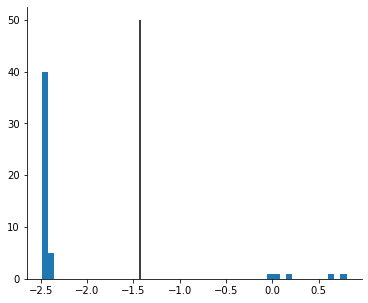

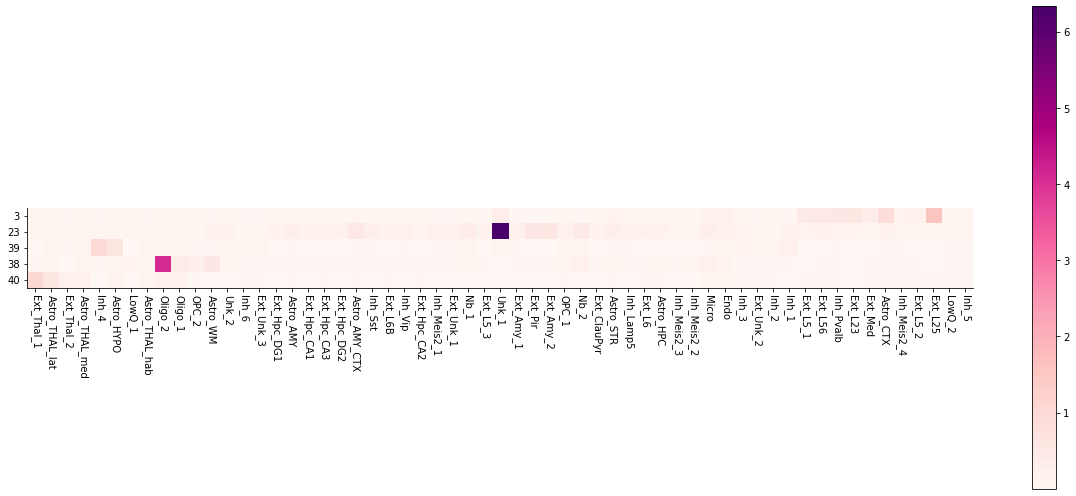

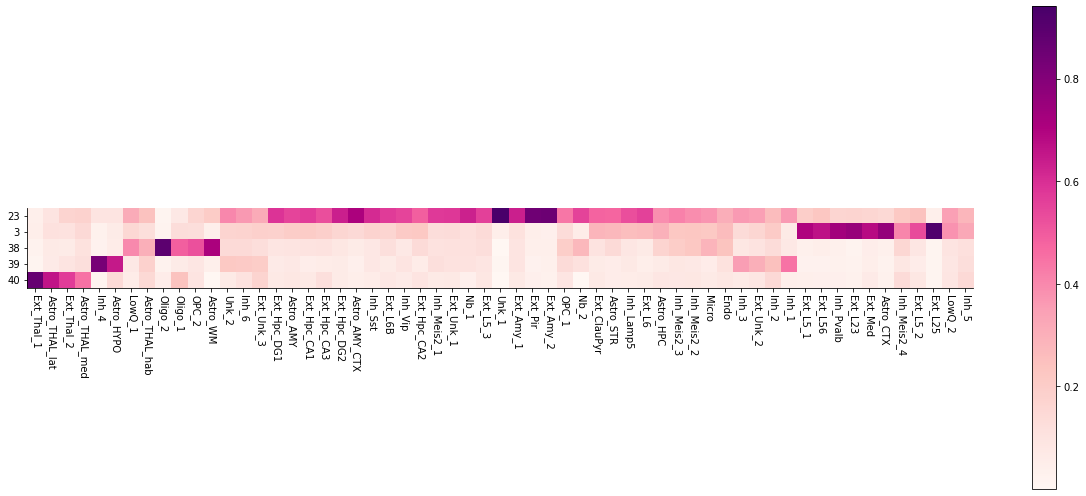

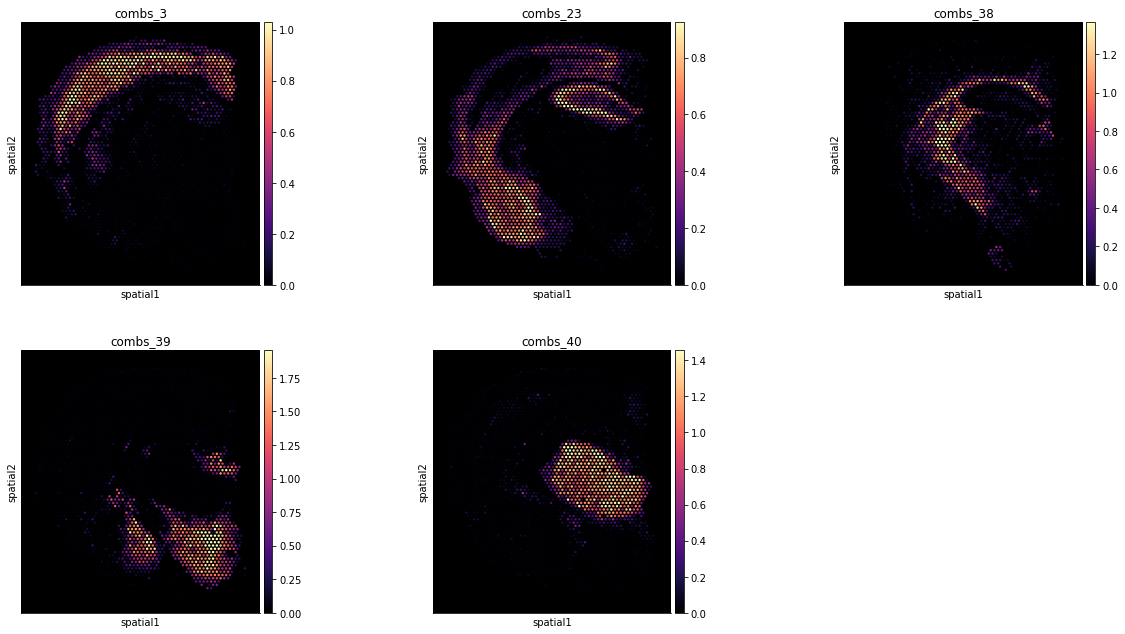

In [5]:
from cell2location.plt.plot_heatmap import clustermap
comb2fact_df = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['comb2fact'],
                            columns=adata_vis.uns['mod']['fact_names'])

rcParams["figure.figsize"] = [6, 5]
rcParams["axes.facecolor"] = "white"
plt.hist(np.log10(comb2fact_df.max(1)), bins=50);
thresh = 0.037
plt.vlines(np.log10(thresh), 0, 50);
fact_filt = comb2fact_df.max(1) > thresh

comb2fact_df = comb2fact_df.loc[fact_filt.values, :]

clustermap(comb2fact_df, figure_size=(17, 7))

comb2fact_df_prop = (comb2fact_df / comb2fact_df.sum(0))
clustermap(comb2fact_df_prop, figure_size=(17, 7))

n_combs = adata_vis.uns['mod']['post_sample_means']['combs_factors'].shape[1]
combs_factors = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['combs_factors'],
                             columns=[f'combs_{i}' for i in range(n_combs)],
                             index=adata_vis.uns['mod']['obs_names'])
combs_factors = combs_factors.loc[:, fact_filt.values]
adata_vis.obs[combs_factors.columns] = combs_factors

slide = select_slide(adata_vis, 'ST8059048')
crop_x, crop_y = get_crop_coord(slide)

s = 'spaceranger100_count_30458_ST8059048_mm10-3_0_0_premrna'
rcParams["axes.facecolor"] = "black"
sc.pl.spatial(slide, cmap='magma',
              color=combs_factors.columns, # limit size in this notebook
              library_id=f'{s}',
              ncols=3, 
              size=1, img_key='hires', 
              alpha_img=0,
              vmin=0, vmax='p99.0'
             )

### Fig 3C <a class="anchor" id="Fig3C"></a> 

In [6]:
# identify spot locations to crop near tissue
def get_crop_coord(slide):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

    crop_x = [crop_min[0]-50, crop_max[0]+50]
    crop_y = [crop_min[1]-20, crop_max[1]+0]

    return crop_x, crop_y

def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata_vis[adata_vis.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

### Fig 3E <a class="anchor" id="Fig3E"></a> 

/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


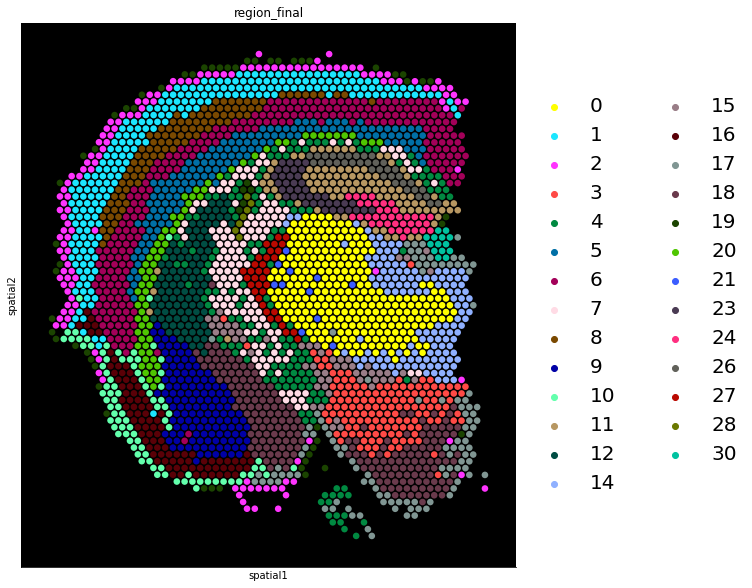

In [14]:
adata_vis = adata_vis[adata_vis.obs['region_final'].astype('int').argsort(),:]
adata_vis.obs['region_final'] = adata_vis.obs['region_final'].astype('category')
cat_order = adata_vis.obs['region_final'].cat.categories.astype(int).sort_values().astype('str')
adata_vis.obs['region_final'].cat.reorder_categories(cat_order, inplace=True)
adata_vis.obs['location'] = adata_vis.obs['location'].astype('category')

s = 'ST8059048'
adata_vis = select_slide(adata_vis, s)
slide = select_slide(adata_vis, s)
crop_x, crop_y = get_crop_coord(slide)

with matplotlib.rc_context({'axes.facecolor':  'black',
                            'figure.figsize': [10, 10]}):


    # Visualize cell type locations
    # making copy to transform to log & assign nice names
    sc.pl.spatial(adata_vis, #cmap='magma',
                  color=['region_final'], ncols=4, 
                  #library_id=s,
                  size=1.3, img_key='hires', alpha_img=0,
                  frameon=True, legend_fontsize=20,
                  #crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
                  vmin=0, vmax='p99.5', save='Fig3E_2D_final_clusters.pdf',
                  palette=sc.pl.palettes.default_102
                 )

/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.uns` of view, copying.


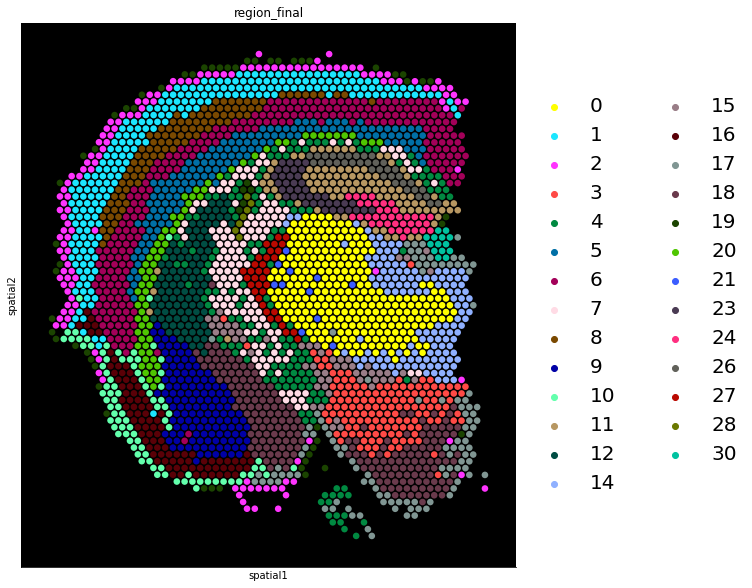

Trying to set attribute `.uns` of view, copying.


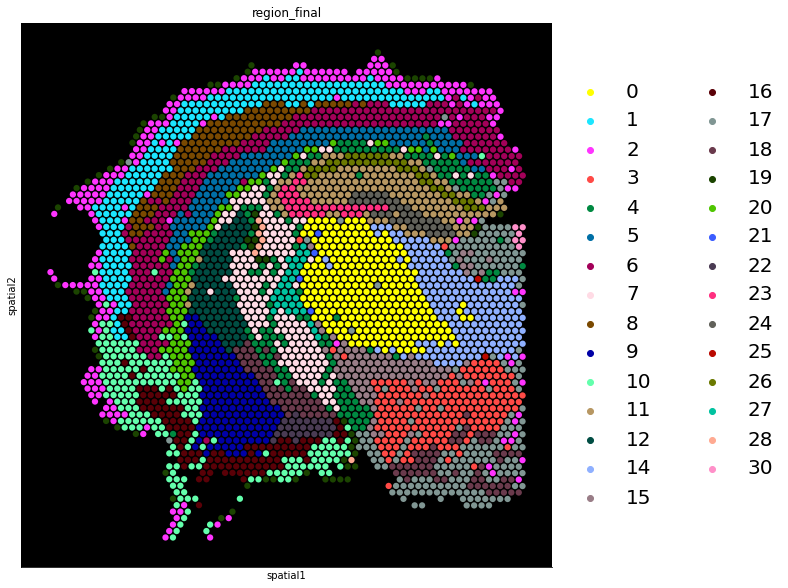

Trying to set attribute `.uns` of view, copying.


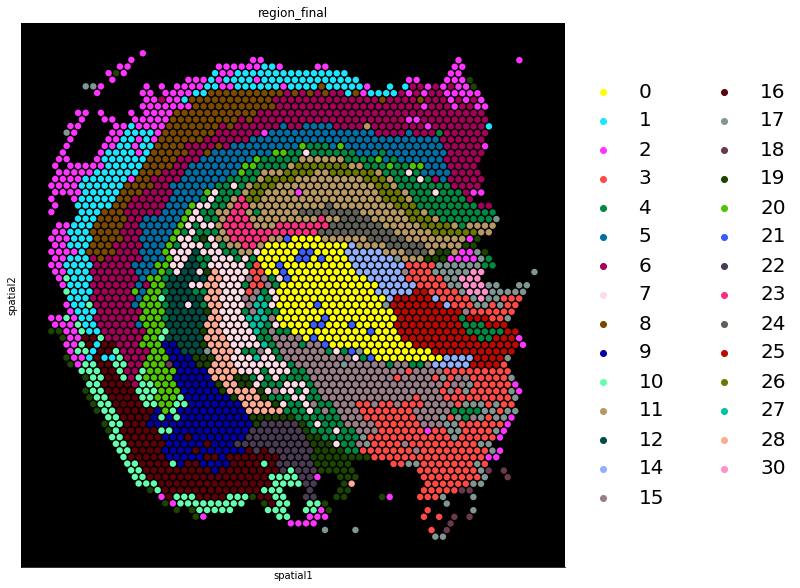

Trying to set attribute `.uns` of view, copying.


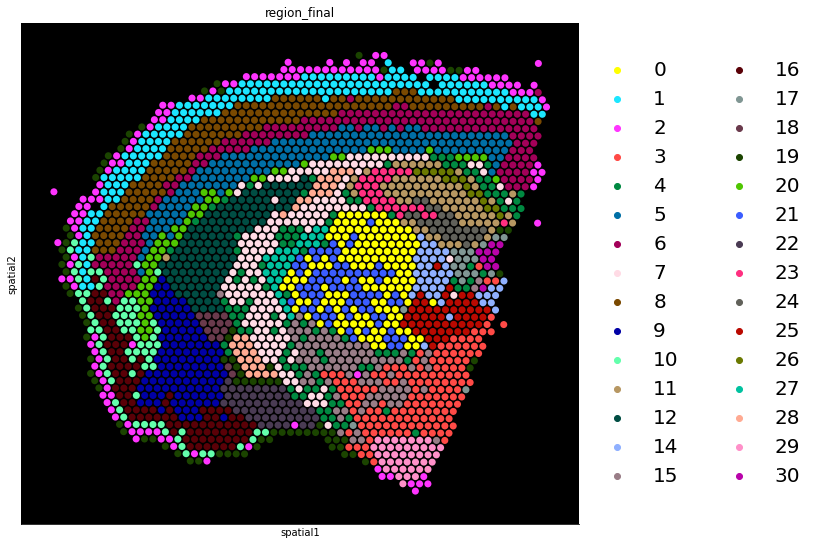

Trying to set attribute `.uns` of view, copying.


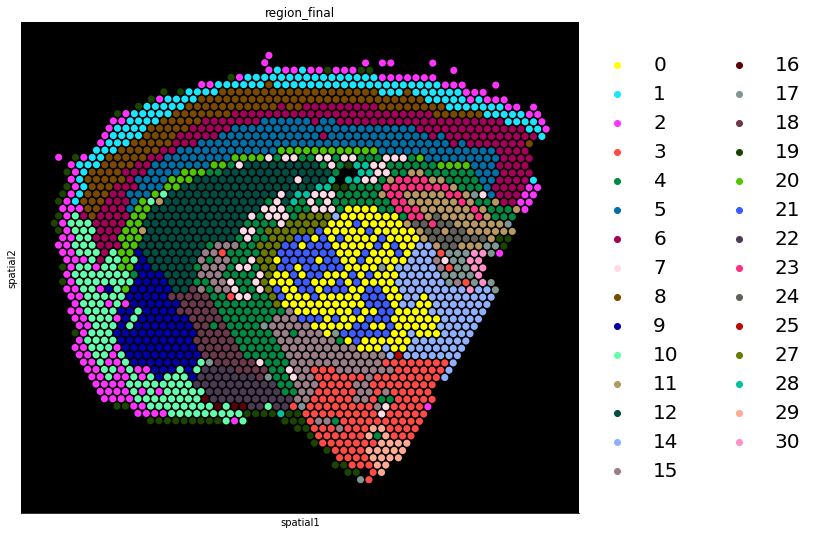

In [10]:
with matplotlib.rc_context({'axes.facecolor':  'black',
                            'figure.figsize': [10, 10]}):

    for s in adata_vis.obs['sample'].unique():
        slide = select_slide(adata_vis, s)
        crop_x, crop_y = get_crop_coord(slide)
        # Visualize cell type locations
        # making copy to transform to log & assign nice names
        sc.pl.spatial(slide, #cmap='magma',
                      color=['region_final'], ncols=4, 
                      #library_id=s,
                      size=1.3, img_key='hires', alpha_img=0,
                      frameon=True, legend_fontsize=20,
                      #crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
                      vmin=0, vmax='p99.5', #save='Fig3E_2D_final_clusters.pdf',
                      palette=sc.pl.palettes.default_102
                     )

/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.uns` of view, copying.


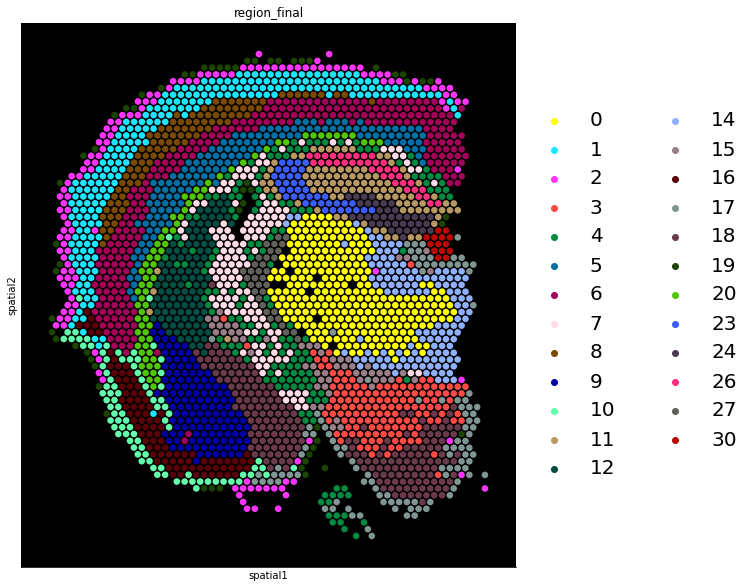

In [11]:
region_final_count = adata_vis.obs["region_final"].value_counts() 
ind = region_final_count.index[region_final_count > 12]
adata_vis = adata_vis[adata_vis.obs["region_final"].isin(ind), :]

with matplotlib.rc_context({'axes.facecolor':  'black',
                            'figure.figsize': [10, 10]}):

    # Visualize cell type locations
    # making copy to transform to log & assign nice names
    sc.pl.spatial(adata_vis, #cmap='magma',
                  color=['region_final'], ncols=4, 
                  #library_id=s,
                  size=1.3, img_key='hires', alpha_img=0,
                  frameon=True, legend_fontsize=20,
                  #crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
                  vmin=0, vmax='p99.5', save='Fig3E_2D_final_clusters.pdf',
                  palette=sc.pl.palettes.default_102
                 )

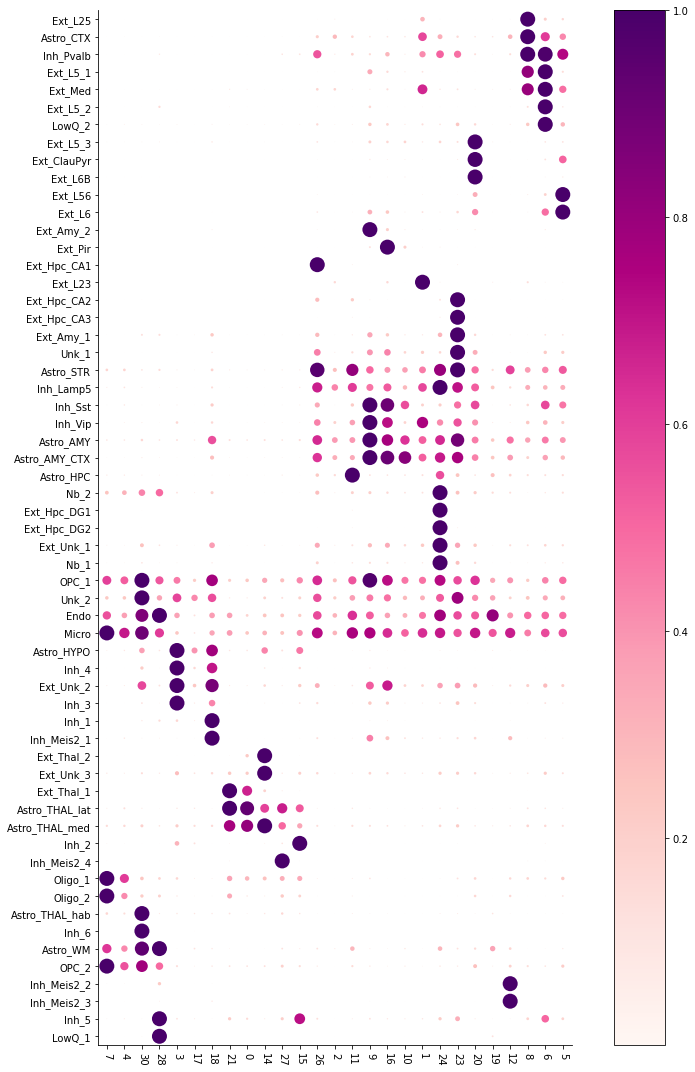

In [15]:
# Compute average abundance of each region cluster
from cell2location.cluster_averages.cluster_averages import get_cluster_averages_df
from cell2location.plt.plot_heatmap import clustermap

ct_aver = get_cluster_averages_df(X=adata_vis.obs[['mean_spot_factors' + i 
                                                      for i in adata_vis.uns['mod']['fact_names']]],
                        cluster_col=adata_vis.obs["region_final"])
ct_aver.index = adata_vis.uns['mod']['fact_names']

# normalise to get 10% of each cell type in each location
ct_aver = (ct_aver.T / ct_aver.max(1)).T
with matplotlib.rc_context({'axes.facecolor':  'white'}):
    clustermap(ct_aver, fun_type='dotplot',
               cluster_rows=True, cluster_cols=True, figure_size=(12, 15))
    #plt.savefig(f'{str(sc.settings.figdir)}/Fig3E_suppl_final_clusters_dotplot.pdf',
    #                bbox_inches='tight', facecolor='white')

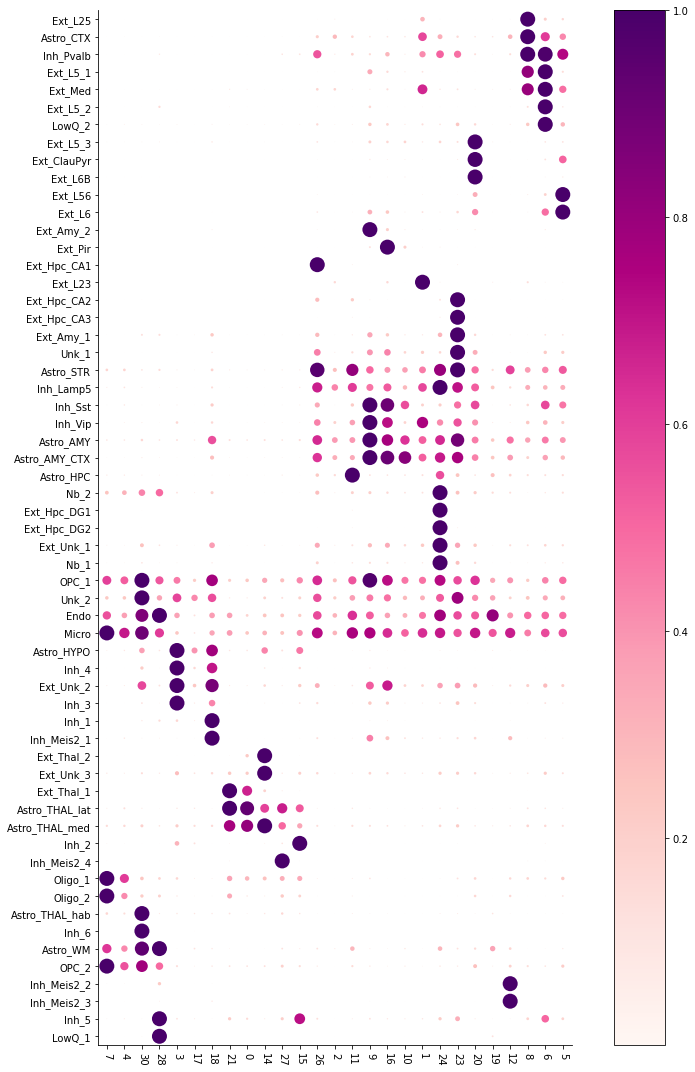

In [20]:
# Compute average abundance of each region cluster
from cell2location.cluster_averages.cluster_averages import get_cluster_averages_df
from cell2location.plt.plot_heatmap import clustermap

ct_aver = get_cluster_averages_df(X=adata_vis.obs[['mean_spot_factors' + i 
                                                      for i in adata_vis.uns['mod']['fact_names']]],
                        cluster_col=adata_vis.obs["region_final"])
ct_aver.index = adata_vis.uns['mod']['fact_names']
#ct_aver.columns = ['region_' + c for c in ct_aver.columns]

# normalise to get 10% of each cell type in each location
ct_aver = (ct_aver.T / ct_aver.max(1)).T
with matplotlib.rc_context({'axes.facecolor':  'white'}):
    clustermap(ct_aver, fun_type='dotplot',#.iloc[linkage['row_ord'], :],
               cluster_rows=True, cluster_cols=True, figure_size=(12, 15))
    plt.savefig(f'{str(sc.settings.figdir)}/Fig3E_suppl_final_clusters_dotplot_one_section.pdf',
                    bbox_inches='tight', facecolor='white')

#### Export the data to plot this heatmap in R

In [16]:
ct_aver = ct_aver.T
ct_aver['region_final'] = ct_aver.index

region_annot = pd.read_csv(f'{sp_results_folder}{run_name}/20200904_regionAnnotation_copy.csv')
region_annot = region_annot.loc[~region_annot['region_04092020'].isna(),:]
region_annot.index = region_annot['region_04092020'].astype(int).astype(str)
region_annot['region_final'] = region_annot['region_final'].astype(int).astype(str)

ct_aver['location'] = region_annot['location'][ct_aver.index]
ct_aver['subregion'] = region_annot['subregion'][ct_aver.index]
ct_aver['cortical_layer'] = region_annot['cortical_layer'][ct_aver.index]

ct_aver['region_final_colors'] = pd.Series(
    adata_vis.uns['region_final_colors'], 
    index=adata_vis.obs['region_final'].astype('category').cat.categories)[ct_aver.index]

ct_aver.to_csv(f'{sp_results_folder}{run_name}/20200904_region_cell_abundances_one_section.csv')
ct_aver

Astro_AMY  Astro_AMY_CTX  Astro_CTX  Astro_HPC  Astro_HYPO  Astro_STR  \
0    0.110788       0.038600   0.022387   0.040088    0.103196   0.057541   
1    0.521301       0.522846   0.579839   0.131928    0.023674   0.456746   
10   0.625543       0.841463   0.098960   0.112027    0.040624   0.373444   
11   0.392381       0.341243   0.177141   1.000000    0.047799   0.813155   
12   0.478080       0.385000   0.305088   0.184440    0.039122   0.591914   
14   0.132604       0.050541   0.023270   0.038517    0.434531   0.061189   
15   0.141630       0.043304   0.024687   0.039757    0.466029   0.079552   
16   0.768775       0.914937   0.112313   0.109883    0.046089   0.395400   
17   0.093985       0.032464   0.010299   0.021370    0.400387   0.048886   
18   0.559509       0.274011   0.029014   0.049324    0.778311   0.187116   
19   0.237025       0.247777   0.103947   0.269611    0.070243   0.151276   
2    0.386488       0.327821   0.290760   0.153775    0.017859   0.273006   
20   0.456306       0.443816   0.104588   0.112969    0.031317   0.488411   
21   0.132853       0.053440   0.022751   0.052724    0.098145   0.076984   
23   0.892566       0.763004   0.161447   0.252147    0.049200   1.000000   
24   0.654935       0.690986   0.327817   0.563695    0.059891   0.803595   
26   0.650245       0.625625   0.208212   0.232819    0.032532   0.964066   
27   0.110182       0.054473   0.035122   0.080366    0.131030   0.079475   
28   0.108749       0.055532   0.036736   0.064679    0.105552   0.147796   
3    0.126055       0.038658   0.016212   0.030136    1.000000   0.068336   
30   0.167722       0.074721   0.023481   0.071322    0.372863   0.113225   
4    0.101915       0.041884   0.034355   0.086825    0.090725   0.180634   
5    0.394444       0.296067   0.429483   0.145592    0.030518   0.537589   
6    0.459634       0.364507   0.607734   0.133864    0.036124   0.430236   
7    0.104266       0.038644   0.021508   0.085948    0.060292   0.177323   
8    0.360178       0.198006   1.000000   0.143997    0.038637   0.382314   
9    1.000000       1.000000   0.108643   0.118492    0.084512   0.501131   

    Astro_THAL_hab  Astro_THAL_lat  Astro_THAL_med  Astro_WM  ...     OPC_2  \
0         0.057124        0.930825        0.809708  0.017755  ...  0.114795   
1         0.027095        0.047998        0.109410  0.035632  ...  0.045009   
10        0.029496        0.029444        0.073545  0.094179  ...  0.081702   
11        0.064437        0.097026        0.144849  0.300666  ...  0.148087   
12        0.042639        0.059114        0.102829  0.179819  ...  0.193146   
14        0.093935        0.592137        1.000000  0.031835  ...  0.125985   
15        0.098574        0.531822        0.353060  0.074350  ...  0.145196   
16        0.043430        0.037741        0.117522  0.048246  ...  0.055080   
17        0.095903        0.092363        0.146532  0.114920  ...  0.059572   
18        0.091058        0.043268        0.156887  0.090931  ...  0.098306   
19        0.108052        0.039943        0.077887  0.361312  ...  0.064477   
2         0.024800        0.023581        0.051052  0.073334  ...  0.014481   
20        0.048879        0.035997        0.103846  0.157201  ...  0.263486   
21        0.116068        1.000000        0.765901  0.051274  ...  0.119314   
23        0.070800        0.111087        0.221488  0.121174  ...  0.087665   
24        0.065867        0.097252        0.179552  0.303071  ...  0.097699   
26        0.038745        0.058236        0.139773  0.120397  ...  0.085599   
27        0.163045        0.681505        0.498457  0.121596  ...  0.199154   
28        0.078605        0.041525        0.106543  1.000000  ...  0.499556   
3         0.097573        0.094651        0.212499  0.038529  ...  0.139119   
30        1.000000        0.079172        0.203022  0.943777  ...  0.783498   
4         0.142032        0.136016        0.161661  0.426212  ...  0.553667   
5         0.039395        0.07

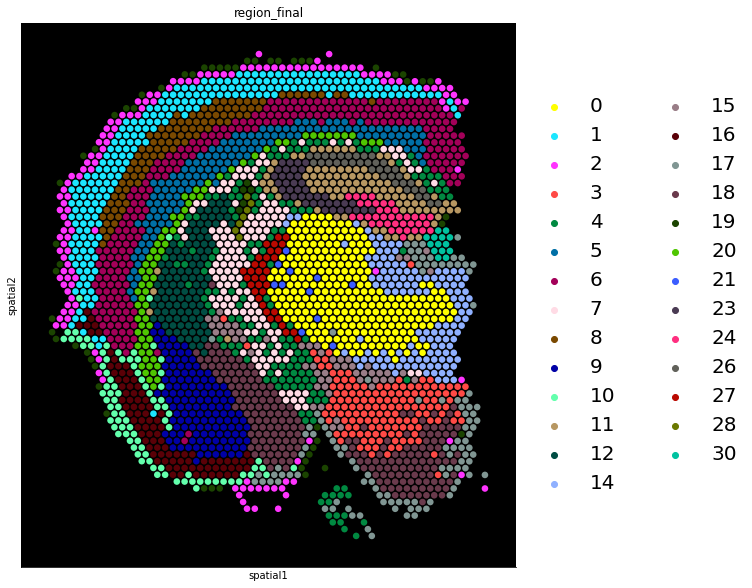

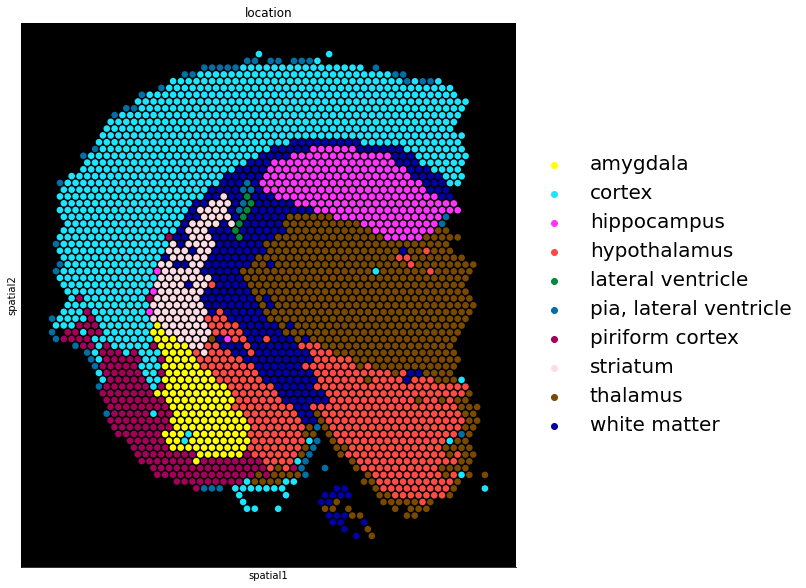

In [17]:
with matplotlib.rc_context({'axes.facecolor':  'black',
                            'figure.figsize': [10, 10]}):
    
    sel_clust = adata_vis.obs['region_final'].cat.categories.isin(slide.obs['region_final'].cat.categories)
    slide.uns['region_final_colors'] = list(np.array(adata_vis.uns['region_final_colors'])[sel_clust])
    sc.pl.spatial(slide, #cmap='magma',
                  color=['region_final'], ncols=4, 
                  #library_id=s,
                  size=1.3, img_key='hires', alpha_img=0,
                  frameon=True, legend_fontsize=20,
                  #crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
                  vmin=0, vmax='p99.5', save='Fig3E_2D_final_clusters_one_section.pdf',
                  #palette=sc.pl.palettes.default_102
                 )
    
    sc.pl.spatial(slide, #cmap='magma',
                  color=['location'], ncols=4, 
                  #library_id=s,
                  size=1.3, img_key='hires', alpha_img=0,
                  frameon=True, legend_fontsize=20,
                  #crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
                  vmin=0, vmax='p99.5', save='Fig3E_suppl_2D_broad_locations_one_section.pdf',
                  palette=sc.pl.palettes.default_102
                 )

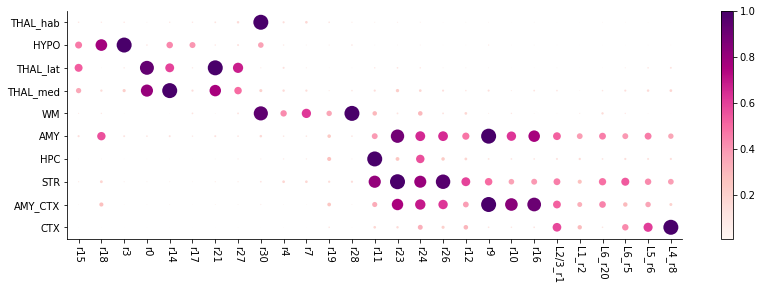

In [18]:
# load order of clusters and regions from R
ct_aver = pd.read_csv(f'{str(sc.settings.figdir)}/Fig3E_astro_location_pheatmap_one_section.csv',
                      index_col=0)
ct_aver = ct_aver[ct_aver.columns[::-1]]

with matplotlib.rc_context({'axes.facecolor':  'white'}):
    clustermap(ct_aver, fun_type='dotplot',#.iloc[linkage['row_ord'], :],
               cluster_rows=False, cluster_cols=False, figure_size=(12, 4), equal=True)
    plt.savefig(f'{str(sc.settings.figdir)}/Fig3E_final_clusters_astro_dotplot_one_section.pdf',
                    bbox_inches='tight', facecolor='white')

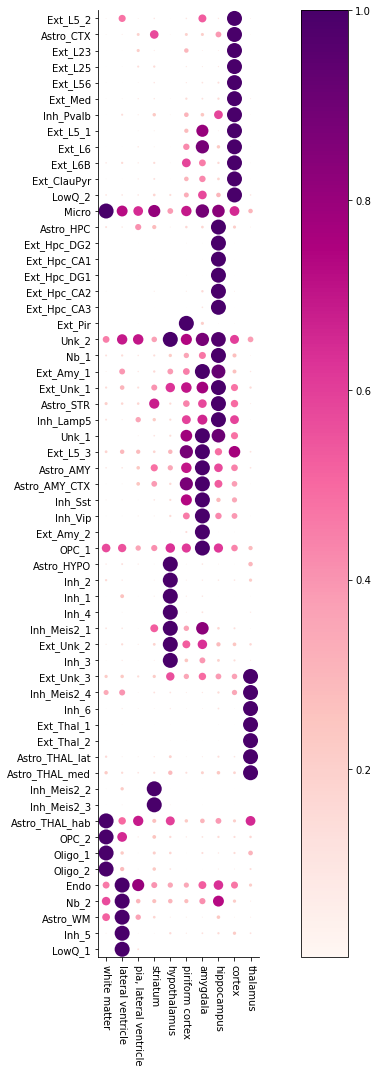

In [19]:
# Compute average abundance of each region cluster
from cell2location.cluster_averages.cluster_averages import get_cluster_averages_df
from cell2location.plt.plot_heatmap import clustermap
#plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
#plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

ct_aver = get_cluster_averages_df(X=adata_vis.obs[['mean_spot_factors' + i 
                                                      for i in adata_vis.uns['mod']['fact_names']]],
                        cluster_col=adata_vis.obs["location"])
ct_aver.index = adata_vis.uns['mod']['fact_names']
ct_aver.columns = ct_aver.columns

# normalise to get 10% of each cell type in each location
ct_aver = (ct_aver.T / ct_aver.max(1)).T
with matplotlib.rc_context({'axes.facecolor':  'white'}):
    clustermap(ct_aver, fun_type='dotplot',#.iloc[linkage['row_ord'], :],
               cluster_rows=True, cluster_cols=True, figure_size=(12, 15))
    plt.savefig(f'{str(sc.settings.figdir)}/Fig3E_suppl_location_dotplot_one_section.pdf',
                    bbox_inches='tight', facecolor='white')